# [ASM] 1st Report - Inventory Optimization

## Finding optimal solution with base parameters

**Parameters:**
- storage cost - `h` = `0.25`
- profit per unit - `c` = `3.50`
- probability of successful delivery - `p` = `0.95`
- fixed order cost - `K` = `150.0`
- variable order cost - `k` = `0.40`
- penalty per lost unit - `l` = `2.0`
- initial inventory - `init_S` = `200`
- average demand = `180`

In [4]:
import Pkg; Pkg.add("VegaLite")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [5]:
using Random
using Distributions
using Statistics
using DataFrames
using VegaLite
using GLM
using Plots

In [6]:
function simulateOneRun(m, s, S;
        h  = 0.25,     # storage cost 
        c  = 3.50,     # unit profit
        p  = 0.95,     # probability of successful delivery
        K  = 150.0,    # fixed order cost
        k  = 0.40,     # variable order cost
        l  = 2.0,      # penalty per lost unit
        init_S = 200,  # initial inventory
        average_demand = 180)

    inv = init_S                    # inventory at start
    profit       = 0.0
    lost_total   = 0.0
    levels_begin = Int[]            # inventory at start of each day
    pois         = Poisson(average_demand)

    for day in 1:m
        # --- reorder if needed ---
        if inv < s && rand() < p
            profit -= K + (S - inv) * k
            inv = S
        end

        push!(levels_begin, inv)    # inventory BOD

        # --- demand & sales ---
        demand = rand(pois)
        sales  = min(inv, demand)
        inv   -= sales
        lost   = demand - sales # stock-out

        # --- Update profit ---
        profit += sales*c          # revenue
        profit -= inv*h            # holding cost (EOD)
        profit -= lost*l           # stock-out penalty

        lost_total += lost
    end

    return (profit = profit,
            lost_orders = lost_total,
            inventory_begin = levels_begin)
end

simulateOneRun (generic function with 1 method)

In [7]:
function run_sims(m,s,S,N=100)
    df = DataFrame(simulateOneRun(m,s,S) for n in 1:N)
    (
        m=m,
        s=s,
        S=S,
        N=N,
        profit_mean = mean(df.profit),
        profit_std = std(df.profit),
        lost_mean = mean(df.lost_orders),
        lost_std = std(df.lost_orders)
    )
end

run_sims (generic function with 2 methods)

In [8]:
Random.seed!(0)
df = DataFrame(run_sims(365,s,S,100) 
    for S in 50:50:1000, s in 50:50:1000 if S > s )

best_row = argmax(df.profit_mean)
df[best_row,:]

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
45,365,150,550,100,1.6031e5,2068.61,1579.57,421.32


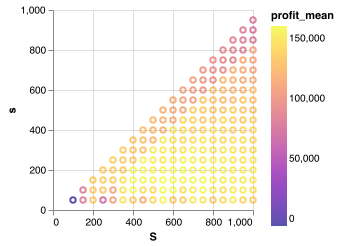

In [9]:
df |> @vlplot(:point, x=:S, y=:s, color={:profit_mean, scale={scheme=:plasma}})

In [10]:
Random.seed!(0)
df_fine = DataFrame(run_sims(365, s, S, 1000)
    for S in 300:10:700, s in 50:10:400 if S > s)

best_row_fine = argmax(df_fine.profit_mean)
@show df_fine[best_row_fine, :]

df_fine[best_row_fine, :] = DataFrameRow
 Row │ m      s      S      N      profit_mean  profit_std  lost_mean  lost_std
     │ Int64  Int64  Int64  Int64  Float64      Float64     Float64    Float64
─────┼──────────────────────────────────────────────────────────────────────────
 479 │   365    160    570   1000    1.61456e5     1957.17    1047.32   411.349


Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
479,365,160,570,1000,1.61456e5,1957.17,1047.32,411.349


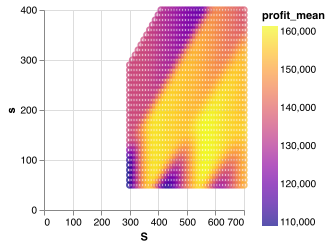

In [11]:
df_fine |> @vlplot(:point, x=:S, y=:s, color={:profit_mean, scale={scheme=:plasma}})

In [12]:
Random.seed!(0)
df_opt = DataFrame(run_sims(365, s, S, 1000)
    for S in 500:5:600, s in 100:5:200 if S > s)

best_row_opt = argmax(df_opt.profit_mean)
@show df_opt[best_row_opt, :]

df_opt[best_row_opt, :] = DataFrameRow
 Row │ m      s      S      N      profit_mean  profit_std  lost_mean  lost_std
     │ Int64  Int64  Int64  Int64  Float64      Float64     Float64    Float64
─────┼──────────────────────────────────────────────────────────────────────────
 289 │   365    165    575   1000     161531.0     1726.42    969.561   355.752


Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
289,365,165,575,1000,161531.0,1726.42,969.561,355.752


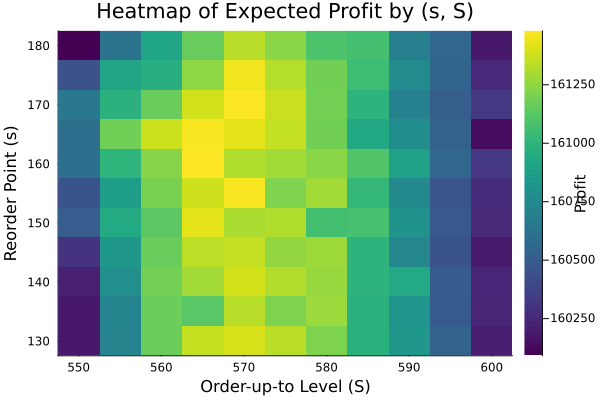

In [56]:
s_vals = 130:5:180  
S_vals = 550:5:600  

profits_matrix = zeros(length(s_vals), length(S_vals))

# Expected profit for each (s, S)
for (i, s_val) in enumerate(s_vals)
    for (j, S_val) in enumerate(S_vals)
        profits_matrix[i, j] = run_sims(365, s_val, S_val, 1000).profit_mean
    end
end

# Heatmap
heatmap(S_vals, s_vals, profits_matrix;
    xlabel = "Order-up-to Level (S)",
    ylabel = "Reorder Point (s)",
    title = "Heatmap of Expected Profit by (s, S)",
    colorbar_title = "Profit",
    color = :viridis)



## Sensitivity Analysis

**Ceteris - paribus analysis**

- Keep all of the parameters unchange
- Change one parameter at a time
- Observe the variation of optimal (s, S) and the expected profit

In [15]:
function run_sims_2(m, s, S; N = 100, param::Symbol=:none, kwargs...)
    df = DataFrame(simulateOneRun(m, s, S; kwargs...) for _ in 1:N)
    return (
        m = m,
        s = s,
        S = S,
        N = N,
        profit_mean = mean(df.profit),
        profit_std  = std(df.profit),
        lost_mean   = mean(df.lost_orders),
        lost_std    = std(df.lost_orders),
        param_value = get(kwargs, param, missing)
    )
end

run_sims_2 (generic function with 1 method)

#### Holding cost - `h`

In [17]:
h_vals = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
s_vals = 140:5:180
S_vals = 550:5:600

sensitivity_df_h = DataFrame()

for h_val in h_vals
    for S in S_vals, s in s_vals
        if S > s
            result = run_sims_2(365, s, S; N=1000, h=h_val, param=:h)
            row = (; result..., h = h_val, s = s, S = S)
            push!(sensitivity_df_h, row)
        end
    end
end

best_per_h = combine(groupby(sensitivity_df_h, :h)) do sub
    sub[argmax(sub.profit_mean), [:h, :s, :S, :profit_mean]]
end

println(best_per_h)


10×4 DataFrame
 Row │ h        s      S      profit_mean    
     │ Float64  Int64  Int64  Float64        
─────┼───────────────────────────────────────
   1 │    0.05    175    600       1.77582e5
   2 │    0.1     180    595       1.73231e5
   3 │    0.15    180    580       1.69139e5
   4 │    0.2     155    575       1.65278e5
   5 │    0.25    170    575       1.61489e5
   6 │    0.3     170    565       1.57743e5
   7 │    0.35    145    565       1.54068e5
   8 │    0.4     150    560  150422.0
   9 │    0.45    155    560       1.46835e5
  10 │    0.5     150    555       1.43222e5


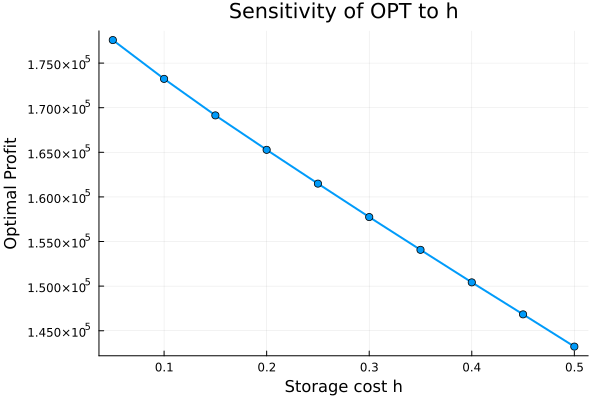

In [18]:
plot(best_per_h.h, best_per_h.profit_mean,
    xlabel = "Storage cost h",
    ylabel = "Optimal Profit",
    title = "Sensitivity of OPT to h",
    legend = false,
    marker = :circle,
    linewidth = 2,
    grid = true)


#### Profit per unit - `c`

7×4 DataFrame
 Row │ c        s      S      profit_mean 
     │ Float64  Int64  Int64  Float64     
─────┼────────────────────────────────────
   1 │   3.0      165    570    1.29147e5
   2 │   3.15     170    565    1.38922e5
   3 │   3.325    165    565    1.50169e5
   4 │   3.5      155    570    1.61506e5
   5 │   3.675    170    570    1.7281e5
   6 │   3.85     160    565    1.84095e5
   7 │   4.0      165    570    1.93815e5


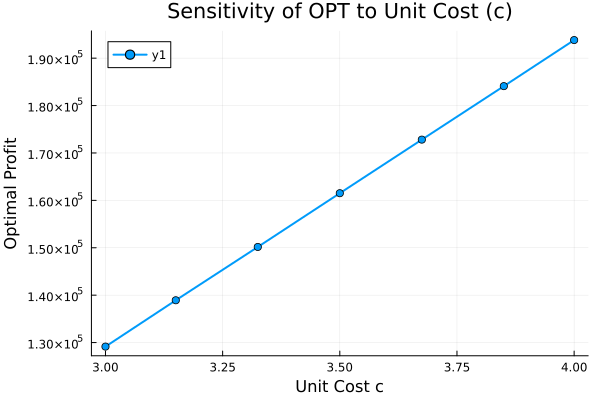

In [22]:
c_vals = [3.0, 3.15, 3.325, 3.50, 3.675, 3.85, 4.0]  

sensitivity_df_c = DataFrame()

for c_val in c_vals
    for S in S_vals, s in s_vals
        if S > s
            result = run_sims_2(365, s, S; N=1000, c=c_val)
            row = (; result..., c = c_val, s = s, S = S)
            push!(sensitivity_df_c, row)
        end
    end
end

best_per_c = combine(groupby(sensitivity_df_c, :c)) do sub
    sub[argmax(sub.profit_mean), [:c, :s, :S, :profit_mean]]
end

println(best_per_c)

plot(best_per_c.c, best_per_c.profit_mean,
    xlabel = "Unit Cost c",
    ylabel = "Optimal Profit",
    title = "Sensitivity of OPT to Unit Cost (c)",
    marker = :circle,
    linewidth = 2,
    grid = true)

#### Order cost - `K`

9×4 DataFrame
 Row │ K      s      S      profit_mean    
     │ Int64  Int64  Int64  Float64        
─────┼─────────────────────────────────────
   1 │    50    175    560  173588.0
   2 │    75    175    565       1.70524e5
   3 │   100    170    565       1.67534e5
   4 │   125    150    570       1.64487e5
   5 │   150    160    565       1.61437e5
   6 │   175    145    570       1.58475e5
   7 │   200    155    570       1.55468e5
   8 │   225    155    565       1.52508e5
   9 │   250    150    570       1.49468e5


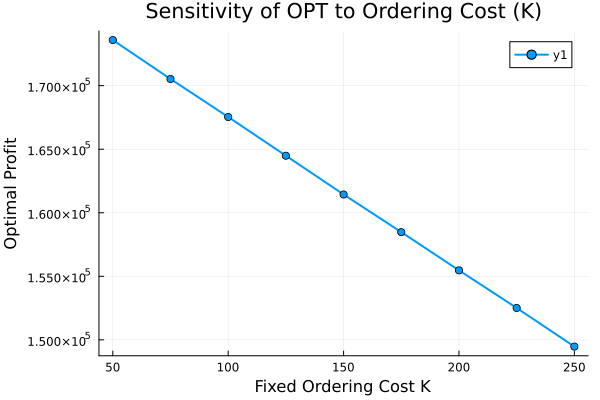

In [24]:
K_vals = [50, 75, 100, 125, 150, 175, 200, 225, 250]
sensitivity_df_K = DataFrame()

for K_val in K_vals
    for S in S_vals, s in s_vals
        if S > s
            result = run_sims_2(365, s, S; N=1000, K=K_val)
            row = (; result..., K = K_val, s = s, S = S)
            push!(sensitivity_df_K, row)
        end
    end
end

best_per_K = combine(groupby(sensitivity_df_K, :K)) do sub
    sub[argmax(sub.profit_mean), [:K, :s, :S, :profit_mean]]
end

println(best_per_K)

plot(best_per_K.K, best_per_K.profit_mean,
    xlabel = "Fixed Ordering Cost K",
    ylabel = "Optimal Profit",
    title = "Sensitivity of OPT to Ordering Cost (K)",
    marker = :circle,
    linewidth = 2,
    grid = true)


In [25]:
# Normalize table h
sensitivity_df_h[!, :c] .= missing
sensitivity_df_h[!, :K] .= missing

# Normalize table c
sensitivity_df_c[!, :h] .= missing
sensitivity_df_c[!, :K] .= missing

# Normalize table K
sensitivity_df_K[!, :h] .= missing
sensitivity_df_K[!, :c] .= missing

# Concat
sensitivity_df = vcat(sensitivity_df_h, sensitivity_df_c, sensitivity_df_K)

# Drop param_value column
select!(sensitivity_df, Not(:param_value))

# Fill missing value by base value
sensitivity_df[!, :h] = coalesce.(sensitivity_df.h, 0.25)
sensitivity_df[!, :c] = coalesce.(sensitivity_df.c, 3.50)
sensitivity_df[!, :K] = coalesce.(sensitivity_df.K, 150.0)

# Display
first(sensitivity_df, 10)

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std,h,c,K
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Real
1,365,140,550,1000,1.74085e5,2067.56,1611.17,434.953,0.05,3.5,150.0
2,365,145,550,1000,1.74119e5,2013.38,1592.13,421.362,0.05,3.5,150.0
3,365,150,550,1000,1.74188e5,1960.73,1574.8,410.362,0.05,3.5,150.0
4,365,155,550,1000,1.74246e5,2047.39,1533.89,427.21,0.05,3.5,150.0
5,365,160,550,1000,1.74593e5,2100.49,1438.64,431.746,0.05,3.5,150.0
6,365,165,550,1000,1.74761e5,1993.46,1349.72,416.619,0.05,3.5,150.0
7,365,170,550,1000,1.74844e5,1965.62,1256.21,411.478,0.05,3.5,150.0
8,365,175,550,1000,1.75175e5,1902.47,1090.47,380.823,0.05,3.5,150.0
9,365,180,550,1000,1.75201e5,1885.77,956.494,383.165,0.05,3.5,150.0


In [26]:
# Linear regression model
model = lm(@formula(profit_mean ~ h + c + K), sensitivity_df)

# Result
println(coeftable(model))

──────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error        t  Pr(>|t|)   Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────
(Intercept)  -27952.5     250.159    -111.74    <1e-99  -28443.0    -27462.0
h            -77754.6     135.794    -572.59    <1e-99  -78020.9    -77488.3
c             64681.6      69.3192    933.10    <1e-99   64545.7     64817.6
K              -120.461     0.32142  -374.78    <1e-99    -121.092    -119.831
──────────────────────────────────────────────────────────────────────────────
